<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Number of time steps: 246
Loop iter. 1 (0.4 %)
Loop iter. 2 (0.8 %)
Loop iter. 3 (1.2 %)
Loop iter. 4 (1.6 %)
Loop iter. 5 (2.0 %)
Loop iter. 6 (2.4 %)
Loop iter. 7 (2.8 %)
Loop iter. 8 (3.3 %)
Loop iter. 9 (3.7 %)
Loop iter. 10 (4.1 %)
Loop iter. 11 (4.5 %)
Loop iter. 12 (4.9 %)
Loop iter. 13 (5.3 %)
Loop iter. 14 (5.7 %)
Loop iter. 15 (6.1 %)
Loop iter. 16 (6.5 %)
Loop iter. 17 (6.9 %)
Loop iter. 18 (7.3 %)
Loop iter. 19 (7.7 %)
Loop iter. 20 (8.1 %)
Loop iter. 21 (8.5 %)
Loop iter. 22 (8.9 %)
Loop iter. 23 (9.3 %)
Loop iter. 24 (9.8 %)
Loop iter. 25 (10.2 %)
Loop iter. 26 (10.6 %)
Loop iter. 27 (11.0 %)
Loop iter. 28 (11.4 %)
Loop iter. 29 (11.8 %)
Loop iter. 30 (12.2 %)
Loop iter. 31 (12.6 %)
Loop iter. 32 (13.0 %)
Loop iter. 33 (13.4 %)
Loop iter. 34 (13.8 %)
Loop iter. 35 (14.2 %)
Loop iter. 36 (14.6 %)
Loop iter. 37 (15.0 %)
Loop iter. 38 (15.4 %)
Loop iter. 39 (15.9 %)
Loop iter. 40 (16.3 %)
Loop iter. 41 (16.7 %)
Loop iter. 42 (17.1 %)
Loop iter. 43 (17.5 %)
Loop iter. 44 (17.

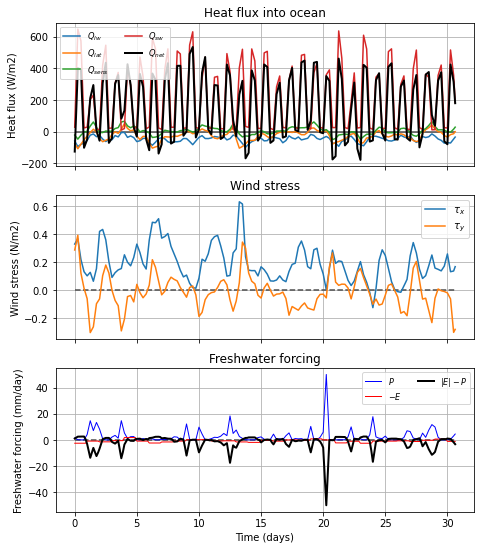

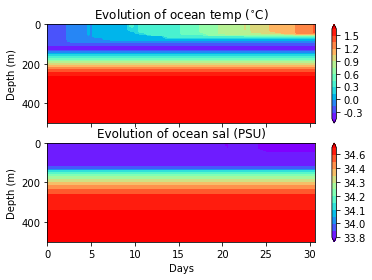

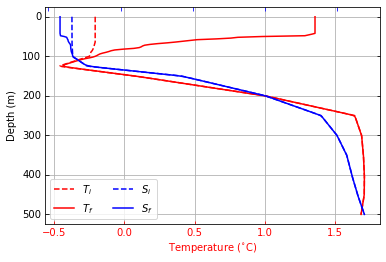

----------------------------------------------------------------------------
NOTE:
See run_demo1() and run_demo2() in PWP_helper.py for more examples.
Additional details can be found here: https://github.com/earlew/pwp_python_00.
----------------------------------------------------------------------------


In [1]:

"""
This is a Python implementation of the Price Weller Pinkel (PWP) ocean mixed layer model. 
This code is based on the MATLAB implementation of the PWP model originally 
written by Peter Lazarevich and Scott Stoermer (http://www.po.gso.uri.edu/rafos/research/pwp/) 
(U. Rhode Island) and later modified by Byron Kilbourne (University of Washington) 
and Sarah Dewey (University of Washington).
The run() function provides an outline of how the code works. 
Earle Wilson
School of Oceanography
University of Washington
April 18, 2016
"""

import numpy as np
import seawater as sw
import matplotlib.pyplot as plt
import xarray as xr
import pickle
import timeit
import os
from datetime import datetime
import PWP_helper as phf
import imp


imp.reload(phf)

#from IPython.core.debugger import Tracer
#debug_here = set_trace

def run(met_data, prof_data, param_kwds=None, overwrite=True, diagnostics=False, suffix='', save_plots=False):
    
    #TODO: move this to the helper file
    """
    This is the main controller function for the model. The flow of the algorithm
    is as follows:
    
        1) Set model parameters (see set_params function in PWP_helper.py). 
        2) Read in forcing and initial profile data.
        3) Prepare forcing and profile data for model run (see prep_data in PWP_helper.py).
            3.1) Interpolate forcing data to prescribed time increments.
            3.2) Interpolate profile data to prescribed depth increments.
            3.3) Initialize model output variables.
        4) Iterate the PWP model specified time interval:
            4.1) apply heat and salt fluxes
            4.2) rotate, adjust to wind, rotate
            4.3) apply bulk Richardson number mixing
            4.4) apply gradient Richardson number mixing
            4.5) apply drag associated with internal wave dissipation
            4.5) apply diapycnal diffusion       
        5) Save results to output file
    
    Input: 
    met_data -  path to netCDF file containing forcing/meterological data. This file must be in the 
                input_data/ directory. 
                
                The data fields should include 'time', 'sw', 'lw', 'qlat', 'qsens', 'tx', 
                'ty', and 'precip'. These fields should store 1-D time series of the same 
                length. 
                
                The model expects positive heat flux values to represent ocean warming. The time
                data field should contain a 1-D array representing fraction of day. For example, 
                for 6 hourly data, met_data['time'] should contain a number series that increases
                in steps of 0.25, such as np.array([1.0, 1.25, 1.75, 2.0, 2.25...]).
    
                See https://github.com/earlew/pwp_python#input-data for more info about the
                expect intput data.
                  
    prof_data - path to netCDF file containing initial profile data. This must be in input_data/ directory.
                The fields of this dataset should include:
                ['z', 't', 's', 'lat']. These represent 1-D vertical profiles of temperature,
                salinity and density. 'lat' is expected to be a length=1 array-like object. e.g. 
                prof_data['lat'] = [25.0].
    
                See https://github.com/earlew/pwp_python#input-data for more info about the
                expect intput data.
    
    overwrite - controls the naming of output file. If True, the same filename is used for 
                every model run. If False, a unique time_stamp is generated and appended
                to the file name. Default is True.
                
    diagnostics - if True, the code will generate live plots of mixed layer properties at 
                each time step.
    
    suffix - string to add to the end of filenames. e.g. suffix = 'nodiff' leads to 'pwp_out_nodiff.nc.
            default is an empty string ''.
    save_plots -this gets passed on to the makeSomePlots() function in the PWP_helper. If True, the code
                saves the generated plots. Default is False.
                
    param_kwds -dict containing keyword arguments for set_params function. See PWP_helper.set_params()
                for more details. If None, default parameters are used. Default is None.
                
    Output:
    
    forcing, pwp_out = PWP.run()
    
    forcing: a dictionary containing the interpolated surface forcing.
    pwp_out: a dictionary containing the solutions generated by the model.
    
    This script also saves the following to file:
    
    'pwp_output.nc'- a netCDF containing the output generated by the model.
    'pwp_output.p' - a pickle file containing the output generated by the model.
    'forcing.p' - a pickle file containing the (interpolated) forcing used for the model run.
    If overwrite is set to False, a timestamp will be added to these file names.
    
    ------------------------------------------------------------------------------
    There are two ways to run the model:
    1.  You can run the model by typing "python PWP.py" from the bash command line. This
        will initiate this function with the set defaults. Typing "%run PWP" from the ipython 
        command line will do the same thing. 
        
    2.  You can also import the module then call the run() function specifically. For example,
        >> import PWP 
        >> forcing, pwp_out = PWP.run()
        Alternatively, if you want to change the defaults...
        >> forcing, pwp_out = PWP.run(met_data='new_forcing.nc', overwrite=False, diagnostics=False)
        
    This is a more interactive approach as it provides direct access to all of the model's
    subfunctions.
        
    """
    
    #close all figures
    plt.close('all')
    
    #start timer
    t0 = timeit.default_timer()
    
    ## Get surface forcing and profile data 
    # These are x-ray datasets, but you can treat them as dicts. 
    # Do met_dset.keys() to explore the data fields
    met_dset = xr.open_dataset('input_data/%s' %met_data) 
    prof_dset = xr.open_dataset('input_data/%s' %prof_data)
    
    ## get model parameters and constants (read docs for set_params function)
    lat = prof_dset['lat'] #needed to compute internal wave dissipation
    if param_kwds is None:
        params = phf.set_params(lat=lat) 
    else:
        param_kwds['lat'] = lat
        params = phf.set_params(**param_kwds)
    
    ## prep forcing and initial profile data for model run (see prep_data function for more details)
    forcing, pwp_out, params = phf.prep_data(met_dset, prof_dset, params)
    
    ## run the model
    pwp_out = pwpgo(forcing, params, pwp_out, diagnostics)
    
         
    ## write output to disk
    if overwrite:
        time_stamp = ''
    else:
        #use unique time stamp
        time_stamp = datetime.now().strftime("_%Y%m%d_%H%M")
    
    if len(suffix)>0 and suffix[0] != '_':
        suffix = '_%s' %suffix
        
    # save output as netCDF file
    pwp_out_ds = xr.Dataset({'temp': (['z', 'time'], pwp_out['temp']), 'sal': (['z', 'time'], pwp_out['sal']), 
                'uvel': (['z', 'time'], pwp_out['uvel']), 'vvel': (['z', 'time'], pwp_out['vvel']),
                'dens': (['z', 'time'],  pwp_out['dens']), 'mld': (['time'],  pwp_out['mld'])}, 
                coords={'z': pwp_out['z'], 'time': pwp_out['time']})

    pwp_out_ds.to_netcdf("output/pwp_output%s%s.nc" %(suffix, time_stamp))

    # also output and forcing as pickle file
    pickle.dump(forcing, open( "output/forcing%s%s.p" %(suffix, time_stamp), "wb" ))
    pickle.dump(pwp_out, open( "output/pwp_out%s%s.p" %(suffix, time_stamp), "wb" ))
    
    #check timer
    tnow = timeit.default_timer()
    t_elapsed  = (tnow - t0)  
    print("Time elapsed: %i minutes and %i seconds" %(np.floor(t_elapsed/60), t_elapsed%60))
    
    ## do analysis of the results
    phf.makeSomePlots(forcing, pwp_out, suffix=suffix, save_plots=save_plots)
    
    return forcing, pwp_out

def pwpgo(forcing, params, pwp_out, diagnostics):

    """
    This is the main driver of the PWP module.
    """
    
    #unpack some of the variables 
    #This is not necessary, but I don't want to update all the variable names just yet.
    q_in = forcing['q_in']
    q_out = forcing['q_out']
    emp = forcing['emp']
    taux = forcing['tx']
    tauy = forcing['ty']
    absrb = forcing['absrb']
    
    z = pwp_out['z']
    dz = pwp_out['dz']
    dt = pwp_out['dt']
    zlen = len(z)
    tlen = len(pwp_out['time'])
    
    rb = params['rb']
    rg = params['rg']
    f = params['f']
    cpw = params['cpw']
    g = params['g']
    ucon = params['ucon']
    
    printDragWarning = True
    
    print("Number of time steps: %s" %tlen)
    
    for n in range(1,tlen):
        percent_comp = 100*n/float(tlen)
        print('Loop iter. %s (%.1f %%)' %(n, percent_comp))
        
        #select for previous profile data
        temp = pwp_out['temp'][:, n-1]
        sal = pwp_out['sal'][:, n-1]
        dens = pwp_out['dens'][:, n-1]
        uvel = pwp_out['uvel'][:, n-1]
        vvel = pwp_out['vvel'][:, n-1]
    
        ### Absorb solar radiation and FWF in surf layer ###
        
        #save initial T,S (may not be necessary)
        temp_old = pwp_out['temp'][0, n-1]
        sal_old = pwp_out['sal'][0, n-1] 
    
        #update layer 1 temp and sal
        temp[0] = temp[0] + (q_in[n-1]*absrb[0]-q_out[n-1])*dt/(dz*dens[0]*cpw)
        #sal[0] = sal[0]/(1-emp[n-1]*dt/dz)
        sal[0] = sal[0] + sal[0]*emp[n-1]*dt/dz
        
        # debug_here()
    
        #check if temp is less than freezing point
        T_fz = sw.fp(sal_old, 1) #why use sal_old? Need to recheck
        if temp[0] < T_fz:
            temp[0] = T_fz
        
        ### Absorb rad. at depth ###
        temp[1:] = temp[1:] + q_in[n-1]*absrb[1:]*dt/(dz*dens[1:]*cpw)
    
        ### compute new density ###
        dens = sw.dens0(sal, temp)
    
        ### relieve static instability ###
        temp, sal, dens, uvel, vvel = remove_si(temp, sal, dens, uvel, vvel)
    
        ### Compute MLD ###       
        #find ml index
        ml_thresh = params['mld_thresh']
        mld_idx = np.flatnonzero(dens-dens[0]>ml_thresh)[0] #finds the first index that exceed ML threshold
    
        #check to ensure that ML is defined
        assert mld_idx.size != 0, "Error: Mixed layer depth is undefined."
    
        #get surf MLD
        mld = z[mld_idx]    
        
        ### Rotate u,v do wind input, rotate again, apply mixing ###
        ang = -f*dt/2
        uvel, vvel = rot(uvel, vvel, ang)
        du = (taux[n-1]/(mld*dens[0]))*dt
        dv = (tauy[n-1]/(mld*dens[0]))*dt
        uvel[:mld_idx] = uvel[:mld_idx]+du
        vvel[:mld_idx] = vvel[:mld_idx]+dv
    

        ### Apply drag to current ###
        #Original comment: this is a horrible parameterization of inertial-internal wave dispersion
        if params['drag_ON']:
            if ucon > 1e-10:
                uvel = uvel*(1-dt*ucon)
                vvel = vvel*(1-dt*ucon)
        else:
            if printDragWarning:
                print("Warning: Parameterization for inertial-internal wave dispersion is turned off.")
                printDragWarning = False

        uvel, vvel = rot(uvel, vvel, ang)
    
        ### Apply Bulk Richardson number instability form of mixing (as in PWP) ###
        if rb > 1e-5:
            temp, sal, dens, uvel, vvel = bulk_mix(temp, sal, dens, uvel, vvel, g, rb, zlen, z, mld_idx)
    
        ### Do the gradient Richardson number instability form of mixing ###
        if rg > 0:
            temp, sal, dens, uvel, vvel = grad_mix(temp, sal, dens, uvel, vvel, dz, g, rg, zlen)
            
        
        ### Apply diffusion ###
        if params['rkz'] > 0:
            temp = diffus(params['dstab'], zlen, temp) 
            sal = diffus(params['dstab'], zlen, sal) 
            dens = sw.dens0(sal, temp)
            uvel = diffus(params['dstab'], zlen, uvel)
            vvel = diffus(params['dstab'], zlen, vvel)
        
        ### update output profile data ###
        pwp_out['temp'][:, n] = temp 
        pwp_out['sal'][:, n] = sal 
        pwp_out['dens'][:, n] = dens
        pwp_out['uvel'][:, n] = uvel
        pwp_out['vvel'][:, n] = vvel
        pwp_out['mld'][n] = mld
    
        #do diagnostics
        if diagnostics==1:
            phf.livePlots(pwp_out, n)
        
    return pwp_out
    

def absorb(beta1, beta2, zlen, dz):
    
    # Compute solar radiation absorption profile. This
    # subroutine assumes two wavelengths, and a double
    # exponential depth dependence for absorption.
    # 
    # Subscript 1 is for red, non-penetrating light, and
    # 2 is for blue, penetrating light. rs1 is the fraction
    # assumed to be red.
    
    rs1 = 0.6
    rs2 = 1.0-rs1
    z1 = np.arange(0,zlen)*dz
    z2 = z1 + dz
    z1b1 = z1/beta1
    z2b1 = z2/beta1
    z1b2 = z1/beta2
    z2b2 = z2/beta2
    absrb = rs1*(np.exp(-z1b1)-np.exp(-z2b1))+rs2*(np.exp(-z1b2)-np.exp(-z2b2))
    
    return absrb
    
def remove_si(t, s, d, u, v):
    
    # Find and relieve static instability that may occur in the
    # density array 'd'. This simulates free convection.
    # ml_index is the index of the depth of the surface mixed layer after adjustment,
    
    stat_unstable = True
      
    while stat_unstable:
        
        d_diff = np.diff(d)
        if np.any(d_diff<0):
            stat_unstable=True
            first_inst_idx = np.flatnonzero(d_diff<0)[0]
            d0 = d
            (t, s, d, u, v) = mix5(t, s, d, u, v, first_inst_idx+1)
            
            #plot density 
            # plt.figure(num=86)
            # plt.clf() #probably redundant
            # plt.plot(d0-1000, range(len(d0)), 'b-', label='pre-mix')
            # plt.plot(d-1000, range(len(d0)), 'r-', label='post-mix')
            # plt.gca().invert_yaxis()
            # plt.xlabel('Density-1000 (kg/m3)')
            # plt.grid(True)
            # plt.pause(0.05)
            # plt.show()
            
            #debug_here()           
        else:
            stat_unstable = False
            
    return t, s, d, u, v
    
    
def mix5(t, s, d, u, v, j):
    
    #This subroutine mixes the arrays t, s, u, v down to level j.
    j = j+1 #so that the j-th layer is included in the mixing
    t[:j] = np.mean(t[:j])
    s[:j] = np.mean(s[:j])
    d[:j] = sw.dens0(s[:j], t[:j])
    u[:j] = np.mean(u[:j])
    v[:j] = np.mean(v[:j])
    
    return t, s, d, u, v
            
def rot(u, v, ang):
    
    #This subroutine rotates the vector (u,v) through an angle, ang
    r = (u+1j*v)*np.exp(1j*ang)
    u = r.real
    v = r.imag
    
    return u, v   
    
def bulk_mix(t, s, d, u, v, g, rb, nz, z, mld_idx):
    #sub-routine to do bulk richardson mixing
    
    rvc = rb #critical rich number??
    
    for j in range(mld_idx, nz):
        h   = z[j]
        #it looks like density and velocity are mixed from the surface down to the ML depth
        dd  = (d[j]-d[0])/d[0]
        dv  = (u[j]-u[0])**2+(v[j]-v[0])**2
        if dv == 0:
            rv = np.inf
        else:
            rv = g*h*dd/dv

        if rv > rvc:
            break
        else:
            t, s, d, u, v = mix5(t, s, d, u, v, j)
            
    return t, s, d, u, v

def grad_mix(t, s, d, u, v, dz, g, rg, nz):
    
    #copied from source script:
    # %  This function performs the gradeint Richardson Number relaxation
    # %  by mixing adjacent cells just enough to bring them to a new
    # %  Richardson Number.      
    # %  Compute the gradeint Richardson Number, taking care to avoid dividing by
    # %  zero in the mixed layer.  The numerical values of the minimum allowable
    # %  density and velocity differences are entirely arbitrary, and should not
    # %  effect the calculations (except that on some occasions they evidently have!)
    #print "entered grad mix"
    
    rc = rg #critical rich. number
    j1 = 0
    j2 = nz-1
    j_range = np.arange(j1,j2)
    i = 0 #loop count
    #debug_here()
    
    while 1:
        #TODO: find a better way to do implement this loop
        
        r = np.zeros(len(j_range))
        
        for j in j_range:
            
            dd = (d[j+1]-d[j])/d[j]
            dv = (u[j+1]-u[j])**2+(v[j+1]-v[j])**2
            if dv==0 or dv<1e-10:
                r[j] = np.inf
            else:
                #compute grad. rich. number
                r[j] = g*dz*dd/dv                
         
        #debug_here()       
        #find the smallest value of r in the profile
        r_min = np.min(r)
        j_min_idx = np.argmin(r)
        
        #Check to see whether the smallest r is critical or not.
        if r_min > rc:
            break
            
        #Mix the cells j_min_idx and j_min_idx+1 that had the smallest Richardson Number
        t, s, d, u, v = stir(t, s, d, u, v, rc, r_min, j_min_idx)
        
        #recompute the rich number over the part of the profile that has changed
        j1 = j_min_idx-2
        if j1 < 1:
             j1 = 0
        
        j2 = j_min_idx+2
        if j2 > nz-1:
             j2 = nz-1
             
        i+=1
                     
    return t, s, d, u, v
                
def stir(t, s, d, u, v, rc, r, j):
    
    #copied from source script:
    
    # %  This subroutine mixes cells j and j+1 just enough so that
    # %  the Richardson number after the mixing is brought up to
    # %  the value rnew. In order to have this mixing process
    # %  converge, rnew must exceed the critical value of the
    # %  richardson number where mixing is presumed to start. If
    # %  r critical = rc = 0.25 (the nominal value), and r = 0.20, then
    # %  rnew = 0.3 would be reasonable. If r were smaller, then a
    # %  larger value of rnew - rc is used to hasten convergence.
    #
    # %  This subroutine was modified by JFP in Sep 93 to allow for an
    # %  aribtrary rc and to achieve faster convergence.
    
    #TODO: This needs better commenting
    rcon = 0.02+(rc-r)/2
    rnew = rc+rcon/5.
    f = 1-r/rnew
    
    #mix temp
    dt = (t[j+1]-t[j])*f/2.
    t[j+1] = t[j+1]-dt
    t[j] = t[j]+dt
    
    #mix sal
    ds = (s[j+1]-s[j])*f/2.
    s[j+1] = s[j+1]-ds
    s[j] = s[j]+ds
    
    #recompute density 
    #d[j:j+1] = sw.dens0(s[j:j+1], t[j:j+1]) 
    #have to be careful here. x[j:j+1] in python is not the same as x[[j,j+1]]. We want the latter
    d[[j,j+1]] = sw.dens0(s[[j,j+1]], t[[j,j+1]])
    
    du = (u[j+1]-u[j])*f/2
    u[j+1] = u[j+1]-du
    u[j] = u[j]+du
    
    dv = (v[j+1]-v[j])*f/2
    v[j+1] = v[j+1]-dv
    v[j] = v[j]+dv
    
    return t, s, d, u, v
    
def diffus(dstab,nz,a):
    
    "finite difference implementation of diffusion equation"
     
    #matlab code:
    #a(2:nz-1) = a(2:nz-1) + dstab*(a(1:nz-2) - 2*a(2:nz-1) + a(3:nz));
    
    a[1:nz-1] = a[1:nz-1] + dstab*(a[0:nz-2] - 2*a[1:nz-1] + a[2:nz]) 
    return a    

if __name__ == "__main__":
    
    forcing_fname ='SO_met_30day.nc' #'beaufort_met.nc'
    prof_fname = 'SO_profile1.nc'#'beaufort_profile.nc'
    p={}
    p['rkz']=1e-6
    p['dz'] = 2.0
    p['max_depth'] = 500.0
#    print("Running Test Case 1 with data from Beaufort gyre...")
#    forcing, pwp_out = run(met_data=forcing_fname, prof_data=prof_fname, suffix='demo1_nodiff', save_plots=True, diagnostics=False)
    forcing, pwp_out = run(met_data=forcing_fname, prof_data=prof_fname, save_plots=True, param_kwds=p)
#    forcing, pwp_out, params = phf.prep_data(met_dset, prof_dset, params)
    print("----------------------------------------------------------------------------")
    print("NOTE:\nSee run_demo1() and run_demo2() in PWP_helper.py for more examples.")
    print("Additional details can be found here: https://github.com/earlew/pwp_python_00.")
    print("----------------------------------------------------------------------------")
